# Tutorial

How to use the classes from the package `catede` in order to estimate quantities such the Shannon entropy and the Kullback-Leibler divergence from categorical data. 

## Histogram of counts
Let's consider as categories $i$ all sequences of length $L=3$ generated from a Markov chain with $20$ states.
The maximum number of possible categories is $K=20^3$.
We extract a sample of $N$ sequences according to the corresponding probability $\boldsymbol{q}=\lbrace q_{i}\rbrace_{i=1}^{K}$.

In [2]:
from catede.handle_ngrams import markov_class

s1 = 12345                                                  # rng seed

#  simulation  #
n_states = 20                                               # n. of states
lenght = 3                                                  # length of the L-grams
K = n_states ** lenght                                      # n. categories a priori

mobj_1 = markov_class(lenght, n_states=n_states, seed=s1)   # Markov matrix
exact_shannon = mobj_1.exact_shannon()                      # exact Shannon entropy

# extract a sample
N = int(1e4)                                                # sample size
seqs_1 = mobj_1.generate_counts(N, seed=s1)                 # generate histogram of counts
print("Histogram of counts")
print(seqs_1)
print(type(seqs_1))

Histogram of counts
3       1
7       1
9       1
12      1
13      4
       ..
7994    1
7997    1
7998    1
7999    1
8000    3
Length: 4486, dtype: int64
<class 'pandas.core.series.Series'>


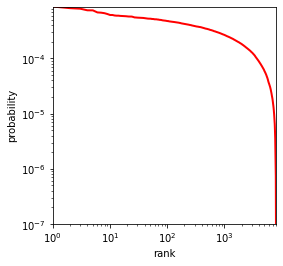

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(4,4))
plt.xlabel('rank')
plt.xscale('log')
plt.ylabel('probability')
plt.yscale('log')
rank_pmf = np.sort(mobj_1.pmf())[::-1]
plt.xlim([1, len(rank_pmf)])
plt.ylim([1e-7, np.max(rank_pmf)])
plt.plot(1+np.arange(len(rank_pmf)), rank_pmf, lw=2, color='red')
plt.show()

## The `Experiment` class 

In [4]:
from catede.estimate import Experiment

# define an Experiment object
exp_1 = Experiment(seqs_1, categories=K)        # first experiment
exp_1.show()                                    # print a short summary of the object

Total n. of counts:
10000
N. of Categories:
4486  (observed)
8000  (a priori)
Multiplicities:
0     3514
1     1976
2     1080
3      667
4      355
5      198
6      106
7       58
8       26
9       11
10       5
11       1
13       1
15       2
Name: freq, dtype: int64


## Shannon entropy estimation

$$
S \left(\boldsymbol{q}\right)
= - \sum_{i=1}^{K} q_{i} \log q_{i}
$$

In [5]:
naive = exp_1.shannon(method='naive') 
cae = exp_1.shannon(method='Chao-Shen') 
nsb, nsb_std = exp_1.shannon(method='NSB', error=True) 

print("Shannon entropy")
print(f"exact : {exact_shannon:.3f}")
print(f"naive : {naive:.3f}")
print(f"CAE : {cae:.3f}")
print(f"NSB : {nsb:.3f} +- {nsb_std:.3f}")

Shannon entropy
exact : 8.591
naive : 8.201
CAE : 8.539
NSB : 8.593 +- 0.005


## Simpson index estimation

$$
\lambda \left(\boldsymbol{q}\right)
=
\sum_{i=1}^{K} {q_{i}}^2
$$

In [ ]:
exact_simpson = mobj_1.exact_simpson()
naive = exp_1.simpson(method='naive')
cae = exp_1.simpson(method='Chao-Shen') 
nsb, nsb_std = exp_1.simpson(method='NSB', error=True)

print("Simpson index")
print(f"exact : {exact_simpson:.6f}")
print(f"naive : {naive:.6f}")
print(f"CAE : {cae:.6f}")
print(f"NSB : {nsb:.6f} +- {nsb_std:.6f}")

## The `Divergence` class

In [ ]:
from catede.estimate import Divergence

# simulation of an independent second system
s2 = 54321                                                  # rng seed

mobj_2 = markov_class(lenght, n_states=n_states, seed=s2)   # random Markov matrix generation
seqs_2 = mobj_2.generate_counts(N, seed=s2)                 # generate histogram of counts
exact_sh_entropy_2 = mobj_2.exact_shannon()                 # exact Shannon entropy  
exp_2 = Experiment(seqs_2, categories=K)                    # second experiment
div_to1from2 = Divergence(exp_1, exp_2)                     # divergence class

## Kullback-Leibler divergence estimation

$$
D_{\rm KL} \left( \boldsymbol{q} \Vert \boldsymbol{t} \right)
=
\sum_{i=1}^{K} q_{i} \log \frac{q_{i}}{t_{i}}
$$

In [ ]:
# Kullback Leibler divergence estimation #
exact_DKL_to1from2 = mobj_1.exact_kullbackleibler(mobj_2)
naive = div_to1from2.kullback_leibler(method='naive')
zhang = div_to1from2.kullback_leibler(method='Zhang-Grabchak') 
dpm, dpm_std = div_to1from2.kullback_leibler(method='DPM', error=True) 

print("Kullback Leibler divergence")
print(f"exact : { exact_DKL_to1from2:.3f}")
print(f"naive : {naive:.3f}")
print(f"ZG : {zhang:.3f}")
print(f"DPM : {dpm:.3f} +- {dpm_std:.3f}")

## symmetrized Kullback-Leibler divergence estimation

$$
sD_{\rm KL} \left( \boldsymbol{q} \Vert \boldsymbol{t} \right)
=
\frac{1}{2} D_{\rm KL} \left( \boldsymbol{q} \Vert \boldsymbol{t} \right) +
\frac{1}{2} D_{\rm KL} \left( \boldsymbol{t} \Vert \boldsymbol{q} \right)
$$

In [ ]:
# Kullback Leibler divergence estimation #
exact_sDKL = 0.5 * (exact_DKL_to1from2 + mobj_2.exact_kullbackleibler(mobj_1))
naive = div_to1from2.symmetrized_KL(method='naive')
zhang = div_to1from2.symmetrized_KL(method='Zhang-Grabchak') 
dpm = div_to1from2.symmetrized_KL(method='DPM') 

print("symm Kullback Leibler divergence")
print(f"exact : { exact_sDKL:.3f}")
print(f"naive : {naive:.3f}")
print(f"ZG : {zhang:.3f}")
print(f"DPM : {dpm:.3f}")

## Squared Hellinger divergence estimation

$$
D_{\rm H}^2 \left( \boldsymbol{q} \Vert \boldsymbol{t} \right)
=
1 - \sum_{i=1}^{K} \sqrt{q_{i}} \sqrt{t_{i}}
$$

In [ ]:
# Squared Hellinger divergence estimation #
exact_DH_to1from2 = mobj_1.exact_squared_hellinger(mobj_2)
naive = div_to1from2.squared_hellinger(method='naive')
dpm, dpm_std = div_to1from2.squared_hellinger(method='DPM', error=True) 

print("Squared Hellinger divergence")
print(f"exact : { exact_DH_to1from2:.3f}")
print(f"naive : {naive:.3f}")
print(f"DPM : {dpm:.3f} +- {dpm_std:.3f}")